In [9]:
# Import libraries
import re
import pandas as pd
from sodapy import Socrata
from dotenv import load_dotenv
import os
import pyvin
import numpy as np
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import shape
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import difflib
tqdm.pandas()

import plotly.express as px

In [82]:
endpoint = 'w4pv-hbkt'
client = run_client('data.ny.gov')

In [83]:
    # Set up query for api. Select only only vehicles from New York City that are electric
query = f"""
    SELECT fuel_type, COUNT(*) AS vc
    GROUP BY fuel_type
"""
# Pull results from DMV registration that are vehicles
results = client.get(endpoint, query=query)
pd.DataFrame.from_records(results)

DEBUG:urllib3.connectionpool:Starting new HTTPS connection (1): data.ny.gov:443
DEBUG:urllib3.connectionpool:https://data.ny.gov:443 "GET /resource/w4pv-hbkt.json?%24query=%0ASELECT+fuel_type%2C+COUNT%28%2A%29+AS+vc%0AGROUP+BY+fuel_type%0A HTTP/1.1" 200 None


,fuel_type,vc
0,COMP N/G,3240
1,DIESEL,479138
2,ELECTRIC,98318
3,FLEX,18124
4,GAS,11077050
5,NONE,589939
6,OTHER,2371
7,PROPANE,941
8,NaN,91742


In [2]:
def run_client(client_url):
    '''
    Input:
        - N/A
    Output:
        - Client data for New York State API
    '''
    #Load enviroment file
    load_dotenv()
    
    # Login to NYS data with enviornment data
    client = Socrata(client_url,
                 os.getenv('nys_dmv_app_token'),
                 username = os.getenv('nys_dmv_api_key_id'),
                 password = os.getenv('nys_dmv_secret'))
    return client

def load_dmv_api(client_url):
    '''
    Input:
        - N/A
    Output:
        - Dataframe with all vehicle registrations in New York that have not expired two years ago
            - The data frame includes only vehicles from New York City that are electric
    '''
    
    # Set up endpoint
    endpoint = 'w4pv-hbkt'
    
    # Get client information
    client = run_client(client_url)
    
    # Get total number of records in api
    query_count = "SELECT COUNT(*)"
    NUM_RECORDS = 1000
    # NUM_RECORDS = int(client.get(endpoint, query = query_count)[0]['COUNT'])
    
    # Set up query for api. Select only only vehicles from New York City that are electric
    query = f"""
        SELECT vin, county, zip
        WHERE record_type = 'VEH'
        AND county in ('NEW YORK')
        AND fuel_type = 'ELECTRIC'
        LIMIT {NUM_RECORDS}
    """
    #
    
    # Pull results from DMV registration that are vehicles
    results = client.get(endpoint, query=query)
    
    # Change results into dataframe
    return pd.DataFrame.from_records(results)

def load_zip_api(client_url):
    '''
    Input:
        - N/A
    Output:
        - Dataframe with NYC zipcodes 
    '''
    
    # Set up endpoint
    endpoint = 'pri4-ifjk'
    
    # Get client information
    client = run_client(client_url)
    
    # Get total number of records in api
    query_count = "SELECT COUNT(*)"
    NUM_RECORDS = int(client.get(endpoint, query = query_count)[0]['COUNT'])
    
    # Set up query for api. Select only only vehicles from New York City that are electric
    query = f"""
        SELECT *
        LIMIT {NUM_RECORDS}
    """
    #
    
    # Pull results from DMV registration that are vehicles
    results = client.get(endpoint, query=query)
    
    # Change results into dataframe
    return pd.DataFrame.from_records(results)

In [50]:
# Load dataset with vin numbers of NYS registered vehicles
df_dmv = load_dmv_api('data.ny.gov')

# Get only vins with the correct number of digits for a person vehicle
df_dmv = df_dmv.loc[df_dmv['vin'].str.len() == 17].copy()

# Drop nan
df_dmv.dropna(inplace = True)

DEBUG:urllib3.connectionpool:Starting new HTTPS connection (1): data.ny.gov:443
DEBUG:urllib3.connectionpool:https://data.ny.gov:443 "GET /resource/w4pv-hbkt.json?%24query=%0A++++++++SELECT+vin%2C+county%2C+zip%0A++++++++WHERE+record_type+%3D+%27VEH%27%0A++++++++AND+county+in+%28%27NEW+YORK%27%29%0A++++++++AND+fuel_type+%3D+%27ELECTRIC%27%0A++++++++LIMIT+1000%0A++++ HTTP/1.1" 200 None


In [51]:
df_dmv['vin'] = df_dmv['vin'].astype(str)

df_dmv['county'] = df_dmv['county'].astype(str)

df_dmv['zip'] = df_dmv['zip'].astype(int)

In [52]:
# df_dmv = df_dmv.sample(1000)

In [53]:
# Change vin numbers to models
df_dmv['model'] = df_dmv['vin'].progress_apply(lambda x: pyvin.VIN(x, error_handling=pyvin.PASS).Model)

  0%|          | 0/996 [00:00<?, ?it/s]

DEBUG:urllib3.connectionpool:https://vpic.nhtsa.dot.gov:443 "POST /api/vehicles/DecodeVINValuesBatch/ HTTP/1.1" 200 1560
DEBUG:urllib3.connectionpool:https://vpic.nhtsa.dot.gov:443 "POST /api/vehicles/DecodeVINValuesBatch/ HTTP/1.1" 200 1559
DEBUG:urllib3.connectionpool:https://vpic.nhtsa.dot.gov:443 "POST /api/vehicles/DecodeVINValuesBatch/ HTTP/1.1" 200 1846
DEBUG:urllib3.connectionpool:https://vpic.nhtsa.dot.gov:443 "POST /api/vehicles/DecodeVINValuesBatch/ HTTP/1.1" 200 1559
DEBUG:urllib3.connectionpool:https://vpic.nhtsa.dot.gov:443 "POST /api/vehicles/DecodeVINValuesBatch/ HTTP/1.1" 200 1554
DEBUG:urllib3.connectionpool:https://vpic.nhtsa.dot.gov:443 "POST /api/vehicles/DecodeVINValuesBatch/ HTTP/1.1" 200 1904
DEBUG:urllib3.connectionpool:https://vpic.nhtsa.dot.gov:443 "POST /api/vehicles/DecodeVINValuesBatch/ HTTP/1.1" 200 1904
DEBUG:urllib3.connectionpool:https://vpic.nhtsa.dot.gov:443 "POST /api/vehicles/DecodeVINValuesBatch/ HTTP/1.1" 200 1904
DEBUG:urllib3.connectionpool:htt

In [54]:
# Drop values if model could not be calculated
df_dmv.dropna(subset=['model'], inplace = True)

# df_dmv.to_csv('ev_with_models.csv',index=False)

In [8]:
# Load emission & range data for epa registered vehicles
df_veh_range = pd.read_csv('https://www.fueleconomy.gov/feg/epadata/vehicles.csv', low_memory=False)

# Change values to float
def func_to_numeric(x):
    return pd.to_numeric(x, errors = 'coerce')
    
df_veh_range[['range','rangeCity','rangeCityA','rangeHwy','rangeHwyA','rangeA']] = df_veh_range[['range','rangeCity','rangeCityA','rangeHwy','rangeHwyA','rangeA']].apply(func_to_numeric)

# Get mean of vehicle ranges
df_veh_range['max_range'] = df_veh_range[['range','rangeCity','rangeCityA','rangeHwy','rangeHwyA','rangeA']].max(axis = 1)

# Get only the model and vehicle range
df_veh_range = df_veh_range[['model','max_range']]

# Drop vehicles without type 2 fuel range
df_veh_range.dropna(subset=['max_range'], inplace = True)

# Group model duplicates and take the max of the duplicates
df_veh_range = df_veh_range.groupby('model').max().reset_index()

# Sort ranges by model names
df_veh_range.sort_values(by = ['model'], inplace = True)

In [55]:
tracker_dict = {}
def get_model_range(model):
    
    df = df_veh_range[df_veh_range.model.str.contains(model, flags=re.IGNORECASE)]
    tracker_dict[model] = df.model.unique()
    return df.max_range.agg({'avg_range': 'mean', 'median_range':'median', 'std_range':'std'})

In [56]:
unique_models = pd.DataFrame(df_dmv.model.unique(), columns=['model'])
unique_models = pd.concat([unique_models,
                           unique_models.model.apply(lambda model: get_model_range(model))],
                          axis=1)

In [57]:
df_dmv = df_dmv.merge(unique_models, how='left', on='model')

In [60]:
df_dmv.isna().sum()

vin              0
county           0
zip              0
model            0
avg_range       78
median_range    78
std_range       78
dtype: int64

In [41]:
df_veh_range[df_veh_range.model.str.contains('lucid', flags=re.IGNORECASE)]

,model,max_range


In [69]:
df_dmv.avg_range.value_counts()

295.973267    524
296.576100    277
306.226443     41
312.950000     39
311.100000     30
32.845416       4
66.359403       1
0.000000        1
0.428571        1
Name: avg_range, dtype: int64

In [72]:
df_dmv.model.value_counts(dropna=False)

Model Y            524
Model X            277
Model 3             41
R1T                 39
R1S                 30
eMOKE               19
Lucid Air           14
GEM                 14
MOKE                12
Kudo Utility         5
                     4
FLY-7                3
SR/F                 2
S, SR                1
FX                   1
FX, FXS, FXP         1
S, SR, SP, SRP       1
DS                   1
Asphalt              1
REDSHIFT             1
ES                   1
Reverse Trike        1
X412 / M4 / M4S      1
EKE-1                1
F-CPX                1
Name: model, dtype: int64

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

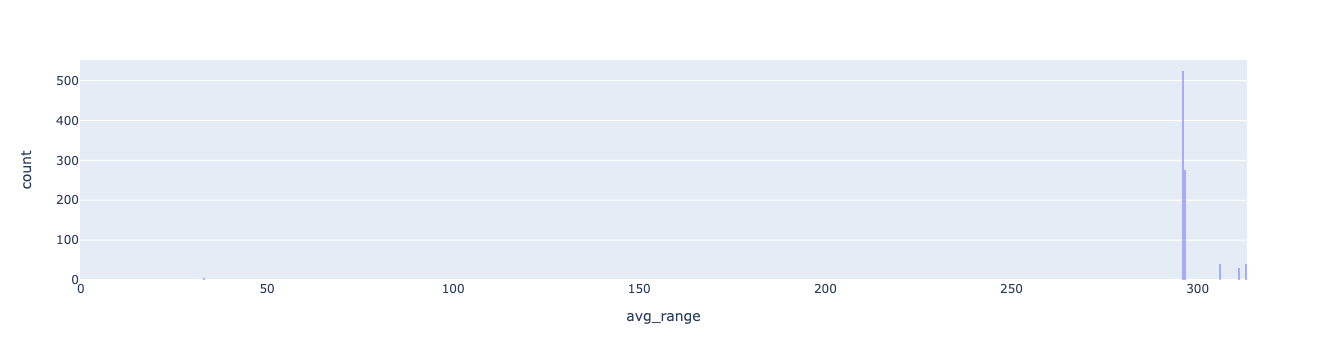

In [63]:
px.histogram(df_dmv, x='avg_range', barmode='overlay', nbins=1000)

In [95]:
df_dmv

,vin,county,zip,model,mean,median,std
0,7SAXCBE6XNF331744,NEW YORK,10011,Model X,296.576100,300.2063,46.541068
1,7SAXCBE5XNF354142,NEW YORK,10012,Model X,296.576100,300.2063,46.541068
2,5YJ3E1EC4MF055842,NEW YORK,10025,Model 3,306.226443,316.1573,36.668553
3,7SAYGDEE4NA010338,NEW YORK,10025,Model Y,295.973267,296.9000,38.871910
4,7SAYGDEF2NF530663,NEW YORK,10033,Model Y,295.973267,296.9000,38.871910
5,7SAYGAEEXPF604971,NEW YORK,10016,Model Y,295.973267,296.9000,38.871910
6,7SAYGDEE7PF626752,NEW YORK,10002,Model Y,295.973267,296.9000,38.871910
7,7SAYGDEF2NF374463,NEW YORK,10065,Model Y,295.973267,296.9000,38.871910
8,7SAXCBE64NF333036,NEW YORK,10028,Model X,296.576100,300.2063,46.541068
9,7SAXCBE53NF334086,NEW YORK,10014,Model X,296.576100,300.2063,46.541068


In [39]:
df_veh_range[df_veh_range.model.str.contains(r".*model(\W+)X.*", flags=re.IGNORECASE, regex=True)]

/var/folders/42/qlm4zcmj6jb69bb7c3htqswc0000gn/T/ipykernel_61093/1196552818.py:1: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  df_veh_range[df_veh_range.model.str.contains(r".*model(\W+)X.*", flags=re.IGNORECASE, regex=True)]


,model,max_range
2880,Model X,348.0000
2881,Model X 100D,299.5437
2882,Model X 75D,242.2000
2883,Model X AWD - 100D,299.5437
2884,Model X AWD - 60D,203.2000
2885,Model X AWD - 75D,242.2000
2886,Model X AWD - 90D,262.7000
2887,Model X AWD - P100D,305.8000
2888,Model X AWD - P90D,252.7000
2889,Model X Long Range,336.3000


In [ ]:
df_veh_range[df_veh_range['model'] == 'Model Y Long Range AWD']

save_df = df_dmv

In [ ]:
# Convert team name in df2 to team name it most closely matches in df1
df_dmv['model'] = df_dmv['model'].apply(lambda x: difflib.get_close_matches(x, df_veh_range['model'], n=1))

df_dmv['model']
# Merge NYS values with model range
# test = df_dmv.merge(df_veh_range, how='left', on='model')

# test

In [ ]:
# Load zipcode data
zip_df = load_zip_api('data.cityofnewyork.us')

# Change geometry into shaply object
zip_df['geometry'] = zip_df['the_geom'].apply(lambda x: shape(x))

# Convert dataframe into geopandas dataframe
gdf_zip = gpd.GeoDataFrame(zip_df, geometry = 'geometry', crs = 'EPSG:4326')
gdf_zip['pop_est'] = gdf_zip['pop_est'].apply(lambda x: float(x))

gdf_zip.plot(column = 'pop_est', 
             legend = True,
             legend_kwds = {
                            'label': "Probability of model X being used in zipcode"
                           }
            )